In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

import os

2024-06-26 20:18:51.025314: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 20:18:52.013547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 20:18:53.324723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
df= pd.read_csv("/home/aya/AI-GuessingGame/data/train_data.csv", sep=";", encoding='cp1252')
len(df), df.head(10)

(652,
                                phrase,hot/cold
 0       A bone-chilling breeze in the air,cold
 1                          The air is icy,cold
 2            A frostbitten morning breeze,cold
 3                  A bone-chilling breeze,cold
 4                      The air is chilled,cold
 5                     An ice-cold morning,cold
 6       The ground is ice-cold and biting,cold
 7          The air is freezing and biting,cold
 8             A deep frost in the morning,cold
 9  The ground is frostbite cold and harsh,cold)

In [3]:
data = []
label = ""
for i,v in df.iterrows():
    e = (v.tolist())[0].split(',')
    label = 1 if e[-1] == 'hot' else 0
        
    data.append([e[0], e[-1], label])

df = pd.DataFrame(data)
# df = df.transpose()
df.columns = ['phrase', 'category', 'label']
df.head(10)

,phrase,category,label
0,A bone-chilling breeze in the air,cold,0
1,The air is icy,cold,0
2,A frostbitten morning breeze,cold,0
3,A bone-chilling breeze,cold,0
4,The air is chilled,cold,0
5,An ice-cold morning,cold,0
6,The ground is ice-cold and biting,cold,0
7,The air is freezing and biting,cold,0
8,A deep frost in the morning,cold,0
9,The ground is frostbite cold and harsh,cold,0


In [4]:
df.category.value_counts()

category
hot     337
cold    315
Name: count, dtype: int64

# Heuristic Approach

In [5]:
import random
truth = random.randint(1, 100)
truth

10

In [6]:
guess = False
comp = 50
tries = 0
l, h = 1, 100

while guess is False:
    print(comp, l, h)
    if comp == truth:
        tries += 1
        guess = True
    else:
        tries+=1
        if comp < truth:
            indicator = 1
            l = comp
        else:
            indicator = 0
            h = comp
            
        comp = random.randint(l, h)
    
    

50 1 100
1 1 50
32 1 50
11 1 32
10 1 11


In [7]:
tries

5

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

# Feature Engineering using Glove Vectors

First, we can use different NLP embeddings to embed the text from the [data](https://github.com/ayanavasarkar/AI-GuessingGame/blob/main/data/train_data.csv) and compare each of their performances based on the hot/cold label. We trained a 1-Dimensional CNN with the training data, though, it is very very small. We embed the text with Glove Vectors for this 1-D CNNs.\
The aim of the CNN is to predict whether the enter user prompt is "HOT" or "COLD".


In [13]:
max_features = 20000
max_text_length = 512


In [25]:
x = train.phrase.values
y = train.label.values

x_test = test.phrase.values
y_test = test.label.values

x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x)+list(x_test))

x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)



In [26]:
embedding_dim =100
embeddings_index = dict()
f = open('/home/aya/AI-GuessingGame/data/glove.6B.100d.txt/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
del f
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [27]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

## 1D CNN with Glove Features

In [28]:
y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=2)
# y_train_plus_val

In [29]:
## CNN Model

model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Define the Optimizers
optimizer = tf.keras.optimizers.Adam(0.0007)
optimizer.learning_rate.assign(0.01)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['f1_score', 'accuracy'])

In [31]:
cnn = model.fit(x_train_val, y_train_plus_val, batch_size=4, validation_split=0.2, epochs=10)

Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6079 - f1_score: 0.5835 - loss: 0.6740 - val_accuracy: 0.7524 - val_f1_score: 0.7078 - val_loss: 0.8173
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8292 - f1_score: 0.8283 - loss: 0.5014 - val_accuracy: 0.9333 - val_f1_score: 0.9313 - val_loss: 0.2262
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9208 - f1_score: 0.9174 - loss: 0.2160 - val_accuracy: 0.9429 - val_f1_score: 0.9413 - val_loss: 0.2240
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9210 - f1_score: 0.9207 - loss: 0.2848 - val_accuracy: 0.9429 - val_f1_score: 0.9420 - val_loss: 0.1528
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9513 - f1_score: 0.9464 - loss: 0.1253 - val_accuracy: 0.9429 - val_f1_score: 0.9420 - val_loss: 0.2354
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9355 - f1_score: 0.9307 - loss: 0.1839 - val_accuracy: 0.9524 - val_f1_score: 

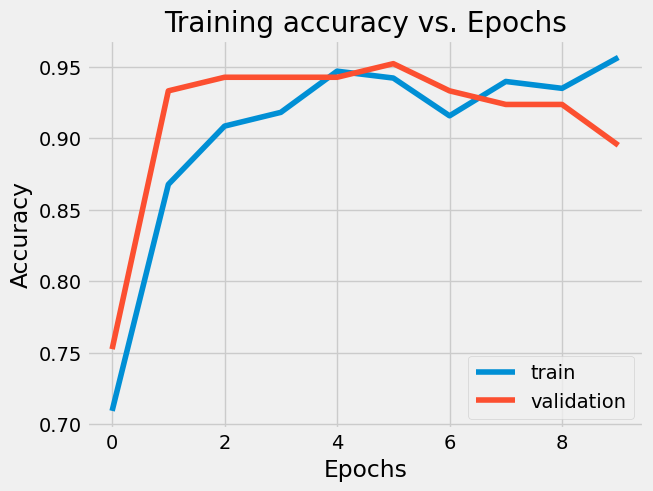

In [32]:
# Plot accuracy
plt.plot(cnn.history['accuracy'], label='train')
plt.plot(cnn.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

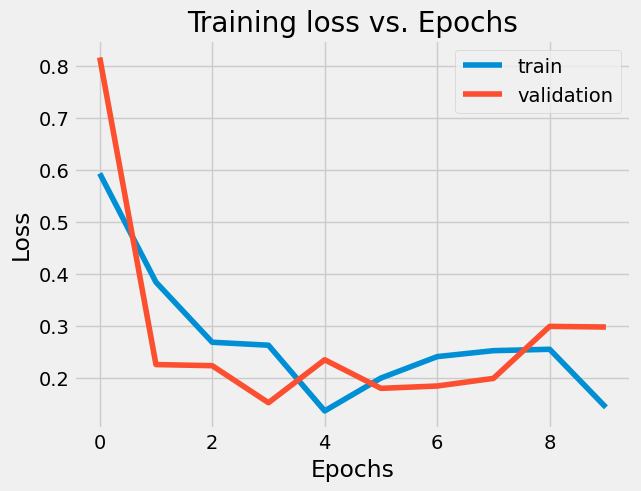

In [33]:
# Plot loss
plt.plot(cnn.history['loss'], label='train')
plt.plot(cnn.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


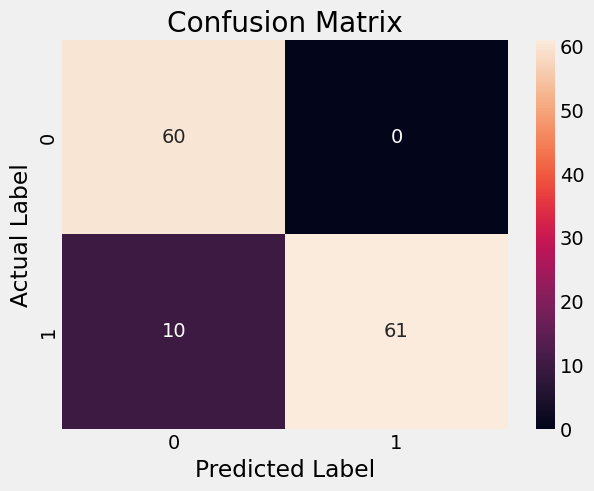

In [34]:

y_pred = model.predict(x_test)
y_pred_ = np.array( [ np.argmax (y) for y in y_pred ] )
cm = confusion_matrix(y_test, y_pred_)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

In [36]:
accuracy_score(y_test, y_pred_),roc_auc_score(y_test, y_pred_),f1_score(y_test, y_pred_)

(0.9236641221374046, 0.9295774647887324, 0.9242424242424242)

In [37]:
len(y), len(y_test)

(521, 131)

In [68]:
model.save('1dcnn_glove.h5')
# cnn = tf.keras.models.load_model("1dcnn_glove.h5")


# Evaluation

## Spacy Large English Model

We can either use the medium or large pre-trained models for the embeddings. `en_core_web_lg`
Then we are going to:
- Take the user entered hints and embed it using the spacy model.
- Then we compare the similarity score between the user entered text hint and the words "HOT" and "COLD" respectively.
- Then we take the maximum similarity score based on whether it is "HOT" or "COLD".


In [38]:
from model import Model
model = Model()
model.load_spacy()

In [40]:
spacy_preds = []
for i,v in test.iterrows():
    spacy_preds.append(model.get_similarity_indicator(v['phrase']))

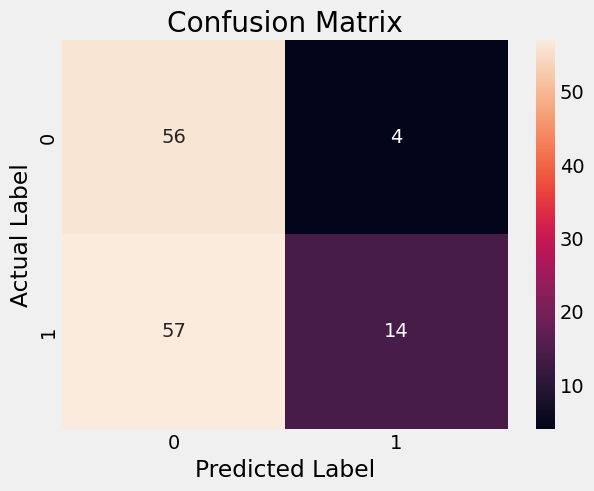

In [41]:
y = df.label.values

cm = confusion_matrix(y_test, spacy_preds)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)

In [43]:
accuracy_score(y_test, spacy_preds),roc_auc_score(y_test, spacy_preds),f1_score(y_test, spacy_preds)

(0.5343511450381679, 0.5652582159624413, 0.3146067415730337)

## Sentence Transformers

In [44]:
from sentence_transformers import SentenceTransformer, util
bert = SentenceTransformer('distilbert-base-nli-mean-tokens')
sentence_embeddings = bert.encode(df.phrase.values)

In [45]:
p = []
h_enc, c_enc = bert.encode("hot"), bert.encode("cold")
import numpy as np
for i, v in test.iterrows():
    # print(bert.encode(v['phrase']))
    scores = [util.pytorch_cos_sim(c_enc, bert.encode(v['phrase'])), util.pytorch_cos_sim(h_enc, bert.encode(v['phrase']))]
    p.append(np.argmax(np.array(scores)))
    # print(score)
    # break

In [47]:
accuracy_score(y_test, p),roc_auc_score(y_test, p),f1_score(y_test, p)

(0.8778625954198473, 0.8731220657276996, 0.8918918918918919)

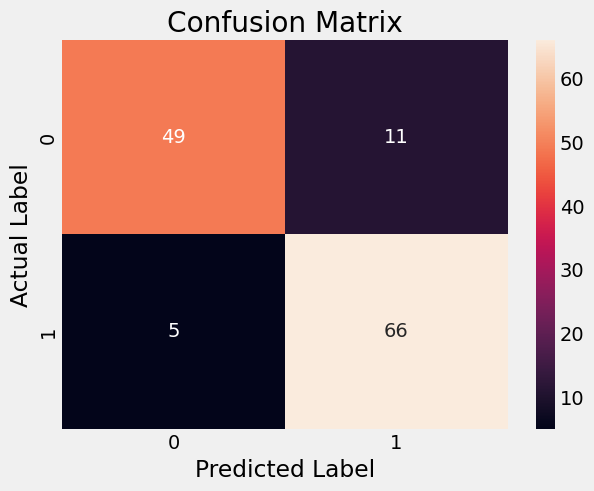

In [48]:
cm = confusion_matrix(y_test, p)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)